<a href="https://colab.research.google.com/github/nickhward/ML_Trading_methods/blob/main/macd_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np

macd_data = pd.read_csv('/content/drive/MyDrive/macd new - macd_strat.csv')

macd_data.head()

,Unnamed: 0,Outcome,Order,Date,EMA,Points,Take Profit,Stop Loss,Entry,Amount,Profit,Challenge Profit,Unnamed: 12
0,0,LOSS,SELL,2015-12-01 10:20:00,17790.52540,94.17,17644.275,17879.70,17785.53,-2000,-2000.0,-2000.0,NaN
1,1,LOSS,BUY,2015-12-02 12:30:00,17829.52727,22.45,17885.585,17829.46,17851.91,-2000,-4000.0,-4000.0,NaN
2,2,LOSS,BUY,2015-12-02 13:35:00,17832.37283,14.46,17865.610,17829.46,17843.92,-2000,-6000.0,-6000.0,NaN
3,3,WIN,SELL,2015-12-14 14:50:00,17348.06082,31.53,17268.295,17347.12,17315.59,3000,-3000.0,-3000.0,NaN
4,4,LOSS,BUY,2015-12-16 12:00:00,17497.78091,42.16,17627.500,17522.10,17564.26,-2000,-5000.0,-5000.0,NaN


Let's delve into some Exploratory Data Analysis (EDA) to better understand the dataset at hand. An essential initial step is to check whether our data is balanced. We'll start by investigating the distribution of our target variable - 'Outcome' - which signifies whether a trade has resulted in a 'Win' or a 'Loss'. It's crucial to understand the balance of these outcomes, as it can significantly impact our model's predictive performance.

In [23]:
 macd_data['Outcome'].value_counts()

LOSS    619
WIN     420
Name: Outcome, dtype: int64

Fortunately, our dataset exhibits only minor imbalance, which is a promising sign. Nevertheless, it's crucial to consider the distinct characteristics of 'buy' and 'sell' trades. These two categories are likely to have different, potentially conflicting, features. To avoid any confusion or interference that might influence our buy/sell strategy, I plan to split the data accordingly, handling 'buys' and 'sells' as separate entities in our analysis and model development.

In [24]:
macd_data['Order'].value_counts()

BUY     762
SELL    277
Name: Order, dtype: int64

In [25]:
macd_sells = macd_data[macd_data['Order'] == 'SELL']
macd_buys = macd_data[macd_data['Order'] == 'BUY']

In [26]:
print(macd_sells['Outcome'].value_counts())
print(macd_buys['Outcome'].value_counts())

LOSS    166
WIN     111
Name: Outcome, dtype: int64
LOSS    453
WIN     309
Name: Outcome, dtype: int64


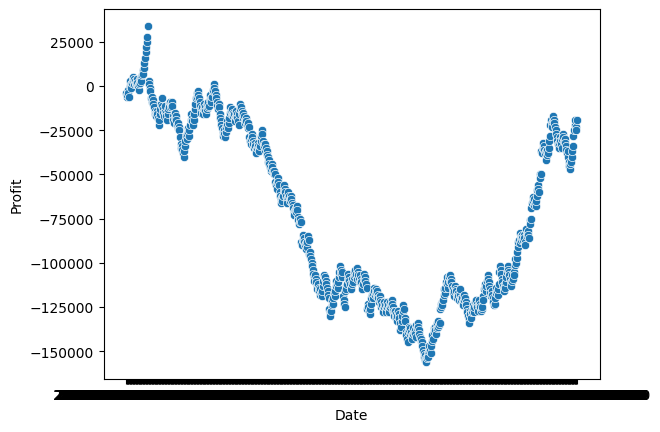

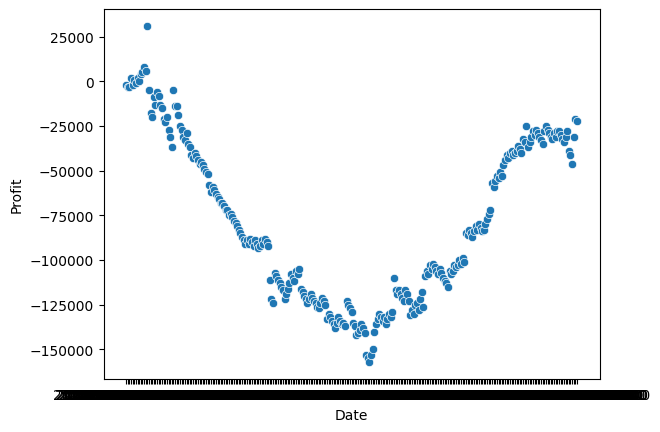

In [27]:
#lets check the current graph for total profit
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='Date', y='Profit', data=macd_buys)
plt.show()

sns.scatterplot(x='Date', y='Profit', data=macd_sells)
plt.show()

The primary objective of this project is to eradicate losses entirely by accurately predicting them. This approach, if successfully implemented, could provide a substantial advantage in the market. Being able to preemptively identify a losing trade allows us to avoid it, enhancing overall profitability. As part of our strategy to achieve this, we'll introduce a few new features derived from the US30 data to help enrich our predictive model.

In [28]:
us30_data = pd.read_csv('/content/drive/MyDrive/file.csv')
#flip data so that we can go by time

us30_data = us30_data.iloc[::-1].reset_index()
us30_data = us30_data.drop('index', axis = 1)

us30_data['200_EMA'] = us30_data['Last'].ewm(span=200, adjust=False).mean()
us30_data.describe()

,Open,High,Low,Last,Change,Volume,200_EMA
count,149333.000000,149333.000000,149333.000000,149333.000000,149333.000000,1.493330e+05,149333.000000
mean,26238.988747,26252.213311,26225.603104,26239.006851,0.103376,3.685441e+06,26228.587180
std,5579.442101,5582.587937,5576.117095,5579.415650,32.911242,6.649631e+06,5576.591825
min,15464.970000,15471.440000,15450.560000,15464.900000,-2250.460000,0.000000e+00,15793.006835
25%,21815.660000,21825.640000,21806.600000,21815.250000,-7.830000,1.722201e+06,21815.681169
50%,25904.940000,25916.540000,25891.990000,25904.550000,0.000000,2.615862e+06,25910.012643
75%,30895.440000,30916.070000,30874.920000,30896.340000,8.230000,3.855830e+06,30910.314944
max,36947.890000,36952.650000,36934.630000,36947.650000,1480.810000,5.693783e+08,36752.325894


In [29]:
#Run this once so that you can pip install ta-lib

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd ..


--2023-05-28 20:19:34--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-05-28 20:19:34--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://newcontinuum.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-05-28 20:19:34--  http://newcontinuum.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving newco

In [30]:
#need to upgrade numpy version otherwise TA-lib will not work when you import it
!pip install TA-Lib
!pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To enrich our dataset and enhance the predictive power of our model, I'll be creating several new features. Once these are prepared, I'll merge them into our existing MACD dataframe, aligning them by their respective time entries. This comprehensive dataset will serve as the foundation for our analysis and modeling efforts.

In [31]:
import talib

def feature_engineering_us30(data):

    def body_wick_ratio(row):
        if row['is_bullish']:
            if abs(row['Open'] - row['Low']) != 0:
                row['body_wick_ratio'] = abs(row['Last'] - row['Open']) / abs(row['Open'] - row['Low'])
            else:
                row['body_wick_ratio'] = 0
        else:
            if abs(row['Last'] - row['Low']) != 0:
                row['body_wick_ratio'] = abs(row['Last'] - row['Open']) / abs(row['Last'] - row['Low'])
            else:
                row['body_wick_ratio'] = 0
        return row['body_wick_ratio']

    exp12     = data['Last'].ewm(span=12, adjust=False).mean()
    exp26     = data['Last'].ewm(span=26, adjust=False).mean()
    macd_line = exp12 - exp26
    signal_line = macd_line.ewm(span=9, adjust=False).mean()

    data['MACD Line'] = macd_line
    data['Signal Line'] = signal_line    

    data['is_bullish'] = (data['Last'] > data['Open']).astype(int)
    data['is_bearish'] = (data['Last'] < data['Last'].shift(1)).astype(int)
    data['candle_size'] = abs(data['Last'] - data['Open'])
    data['body_wick_ratio'] = data.apply(body_wick_ratio, axis=1)

    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Last'], timeperiod=14)

    # 3. Relative Strength Index (RSI)
    data['RSI'] = talib.RSI(data['Last'], timeperiod=14)

    # 5. MACD Histogram
    macd, signal, hist = talib.MACD(data['Last'], fastperiod=12, slowperiod=26, signalperiod=9)
    data['MACD_Hist'] = hist

    # 8. Price Rate of Change (ROC)
    data['ROC'] = talib.ROC(data['Last'], timeperiod=10)

    data['HL'] = data['High'] - data['Low']
    data['absHC'] = abs(data['High'] - data['Last'].shift())
    data['absLC'] = abs(data['Low'] - data['Last'].shift())
    data['TR'] = data[['HL', 'absHC', 'absLC']].max(axis=1)
   
    data['20_SMA'] = data['Last'].rolling(window=20).mean()
    data['20_SD'] = data['Last'].rolling(window=20).std()
    data['Upper_Band'] = data['20_SMA'] + (data['20_SD']*2)
    data['Lower_Band'] = data['20_SMA'] - (data['20_SD']*2)

    data['Log Returns'] = np.log(data['Last']/data['Last'].shift(1))
    data['Historical Volatility'] = data['Log Returns'].rolling(window=21).std() * np.sqrt(252)


    for n in range(1, 6):
        data[f'is_bullish_{n}'] = data['is_bullish'].shift(n)
        data[f'candle_size_{n}'] = data['candle_size'].shift(n)
    # 1. Average True Range (ATR)


    return data

In [32]:
feature_data = feature_engineering_us30(us30_data)
feature_data.rename(columns={'Time':'Date'}, inplace=True)
feature_data.head()


,Date,Open,High,Low,Last,Change,%Chg,Volume,200_EMA,MACD Line,...,is_bullish_1,candle_size_1,is_bullish_2,candle_size_2,is_bullish_3,candle_size_3,is_bullish_4,candle_size_4,is_bullish_5,candle_size_5
0,11/17/2015 09:30,17486.99,17523.64,17486.99,17503.73,20.72,+0.12%,6745474,17503.730000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11/17/2015 09:35,17501.59,17510.94,17476.07,17480.54,-23.19,-0.13%,2175392,17503.499254,-1.849915,...,1.0,16.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11/17/2015 09:40,17480.31,17487.96,17466.98,17481.08,0.54,0.00%,2122478,17503.276177,-3.235119,...,0.0,21.05,1.0,16.74,NaN,NaN,NaN,NaN,NaN,NaN
3,11/17/2015 09:45,17480.61,17483.01,17462.98,17468.85,-12.23,-0.07%,2320527,17502.933628,-5.259139,...,1.0,0.77,0.0,21.05,1.0,16.74,NaN,NaN,NaN,NaN
4,11/17/2015 09:50,17468.92,17480.28,17453.62,17473.63,4.78,+0.03%,2042108,17502.642049,-6.403665,...,0.0,11.76,1.0,0.77,0.0,21.05,1.0,16.74,NaN,NaN


In [33]:
feature_data['Date']

0         11/17/2015 09:30
1         11/17/2015 09:35
2         11/17/2015 09:40
3         11/17/2015 09:45
4         11/17/2015 09:50
                ...       
149328    12/16/2022 16:05
149329    12/16/2022 16:10
149330    12/16/2022 16:15
149331    12/16/2022 16:20
149332    12/16/2022 17:00
Name: Date, Length: 149333, dtype: object

In [34]:
#merge the dataframes

macd_sells['Date'] = pd.to_datetime(macd_sells['Date'])
macd_buys['Date'] = pd.to_datetime(macd_buys['Date'])
feature_data['Date'] = pd.to_datetime(feature_data['Date'])
macd_sells = macd_sells.reset_index()
macd_buys = macd_buys.reset_index()

macd_sells = pd.merge(macd_sells, feature_data, on = 'Date')
macd_buys = pd.merge(macd_buys, feature_data, on='Date')

print(f'Macd_buys shape: {macd_buys.shape}')
print(f'Macd_sells shape: {macd_sells.shape}')

for_later = macd_buys

<ipython-input-34-24e36c35af1a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macd_sells['Date'] = pd.to_datetime(macd_sells['Date'])
<ipython-input-34-24e36c35af1a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macd_buys['Date'] = pd.to_datetime(macd_buys['Date'])


Macd_buys shape: (762, 52)
Macd_sells shape: (277, 52)


In [35]:
dropping = ['200_EMA', 'Unnamed: 12', 'Open', 'High', 'Low', 'Last', 'index', 'Unnamed: 0','Challenge Profit', 'Challenge Profit', 'Entry', 'Amount', 'Profit', 'Change', '%Chg',  'Take Profit', 'Stop Loss', 'Order', 'EMA', 'Date']

macd_sells['distance_ema'] = abs(macd_sells['Low'] - macd_sells['EMA'])
macd_buys['distance_ema'] = abs(macd_buys['Low'] - macd_buys['EMA'])
macd_sells['hour'] = macd_sells['Date'].dt.hour
macd_buys['hour'] = macd_buys['Date'].dt.hour
macd_sells['minute'] = macd_sells['Date'].dt.minute
macd_buys['minute'] = macd_buys['Date'].dt.minute

macd_sells = macd_sells.drop(columns=dropping, axis = 1)
macd_buys = macd_buys.drop(columns=dropping, axis=1)

print(macd_buys.columns)

Index(['Outcome', 'Points', 'Volume', 'MACD Line', 'Signal Line', 'is_bullish',
       'is_bearish', 'candle_size', 'body_wick_ratio', 'ATR', 'RSI',
       'MACD_Hist', 'ROC', 'HL', 'absHC', 'absLC', 'TR', '20_SMA', '20_SD',
       'Upper_Band', 'Lower_Band', 'Log Returns', 'Historical Volatility',
       'is_bullish_1', 'candle_size_1', 'is_bullish_2', 'candle_size_2',
       'is_bullish_3', 'candle_size_3', 'is_bullish_4', 'candle_size_4',
       'is_bullish_5', 'candle_size_5', 'distance_ema', 'hour', 'minute'],
      dtype='object')


I now want to check the distribution of each point 

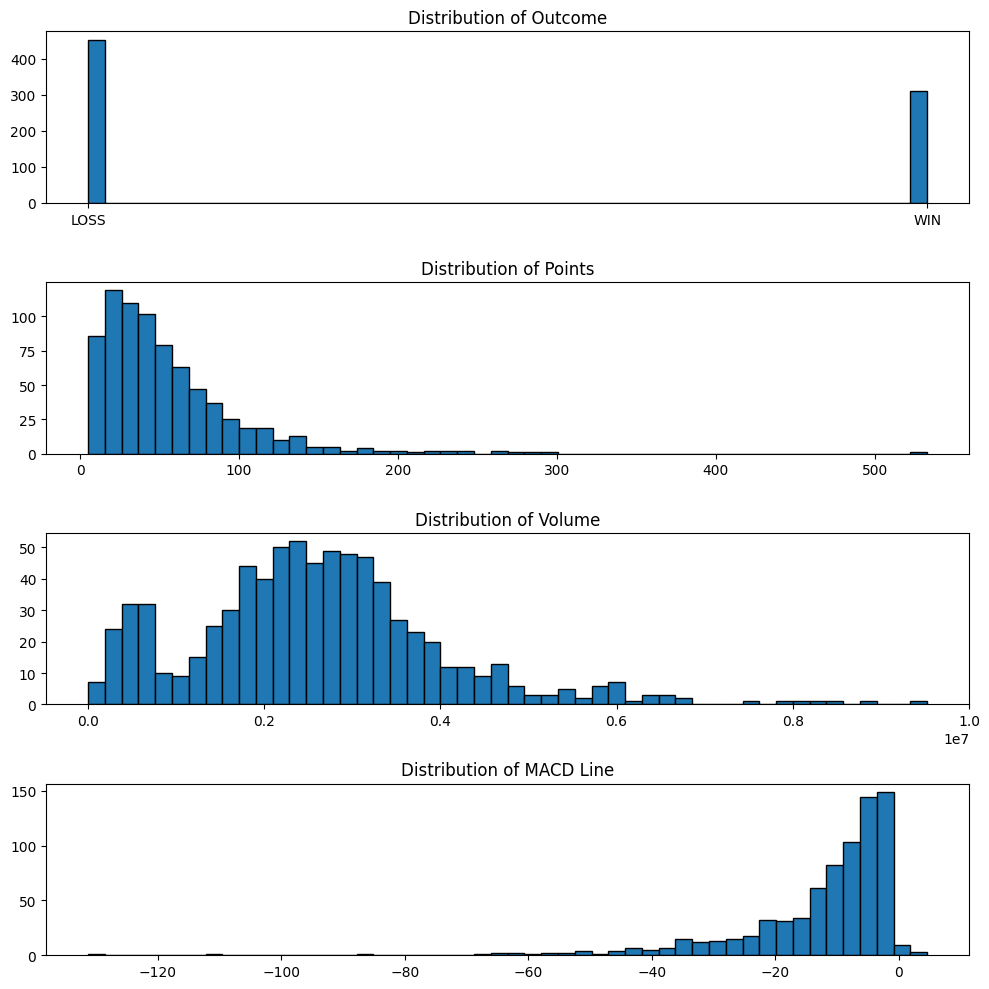

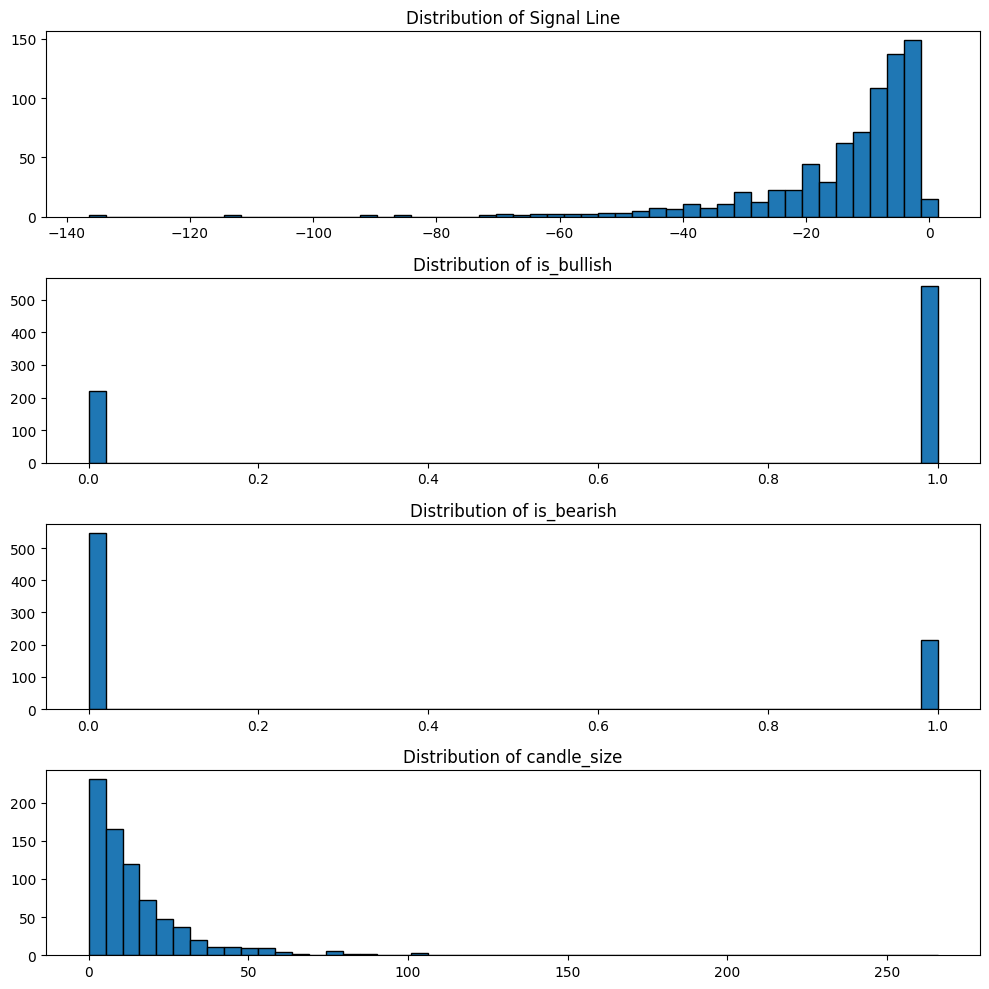

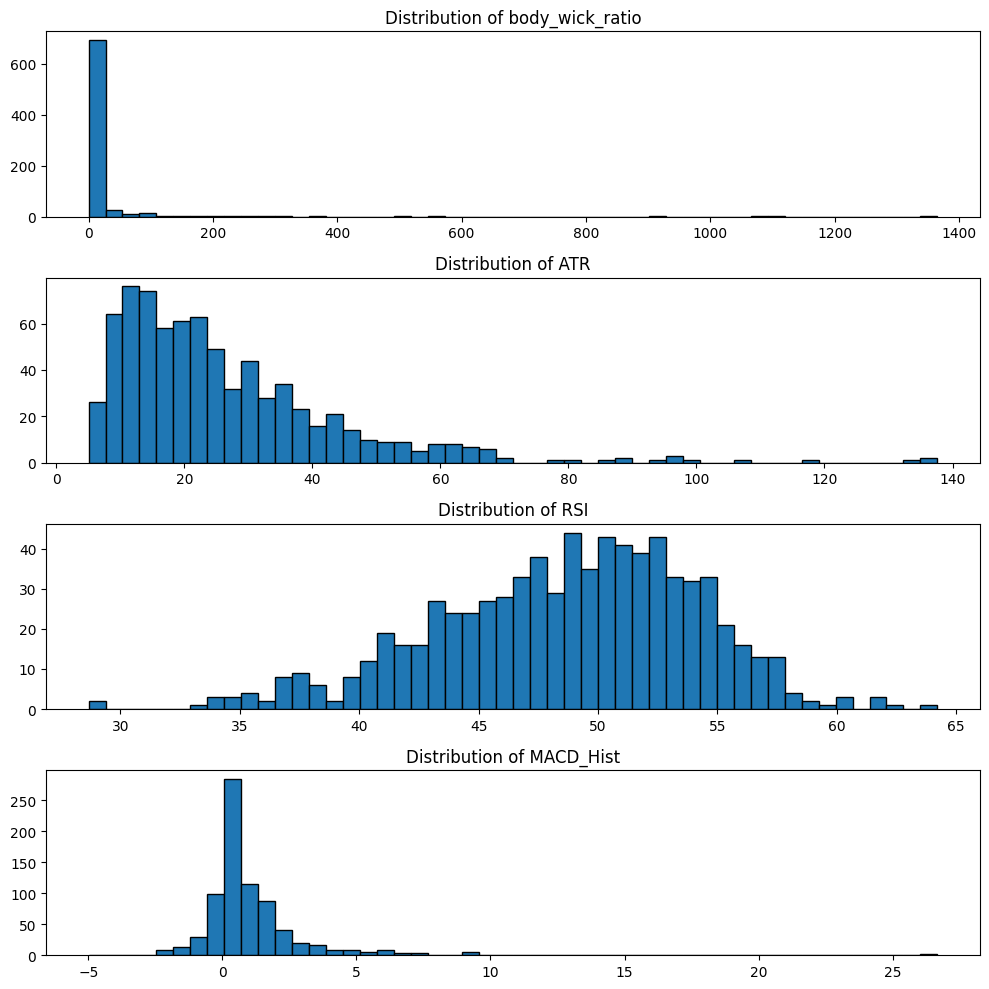

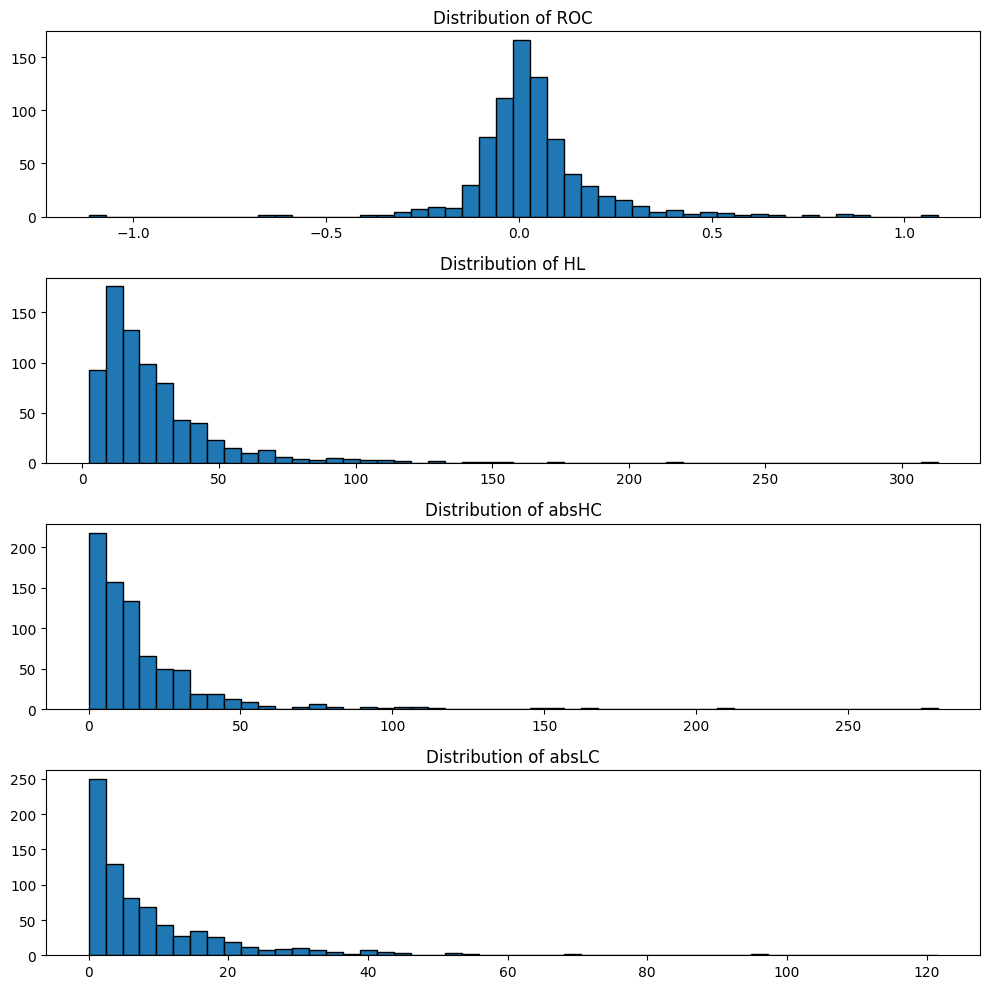

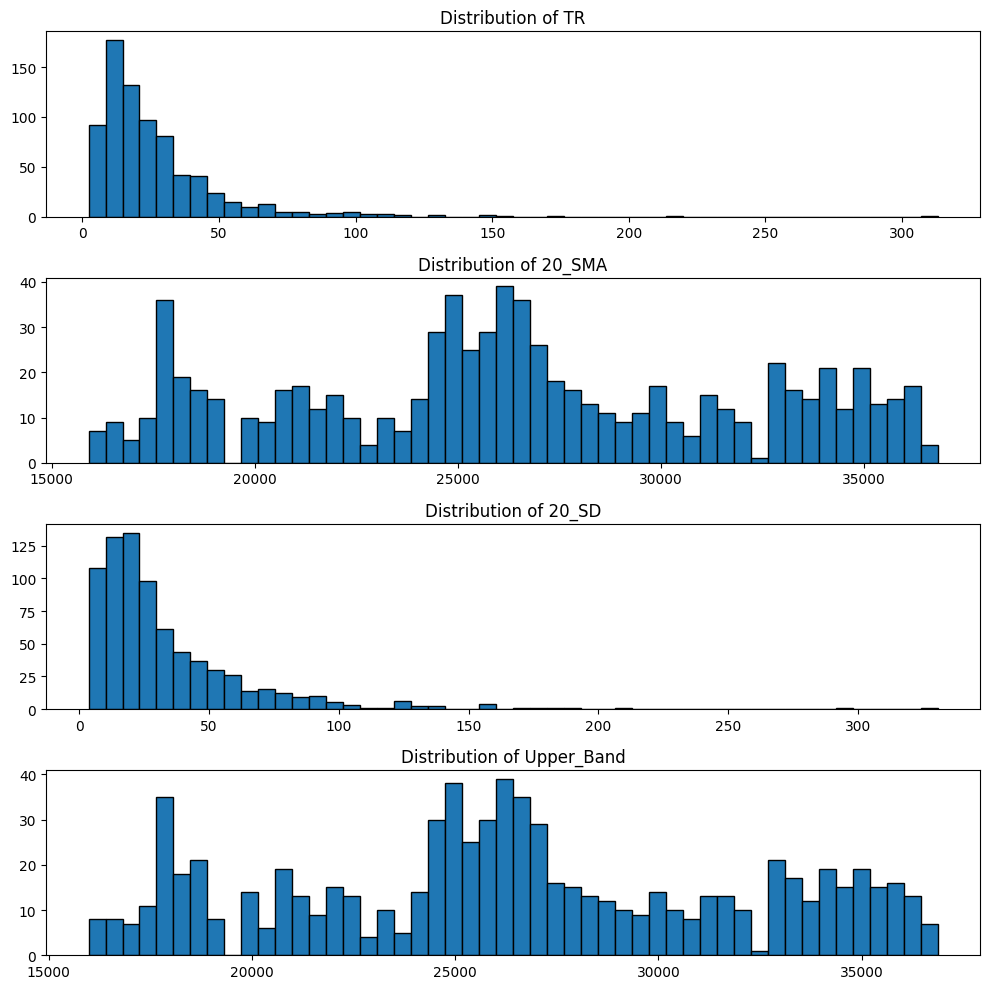

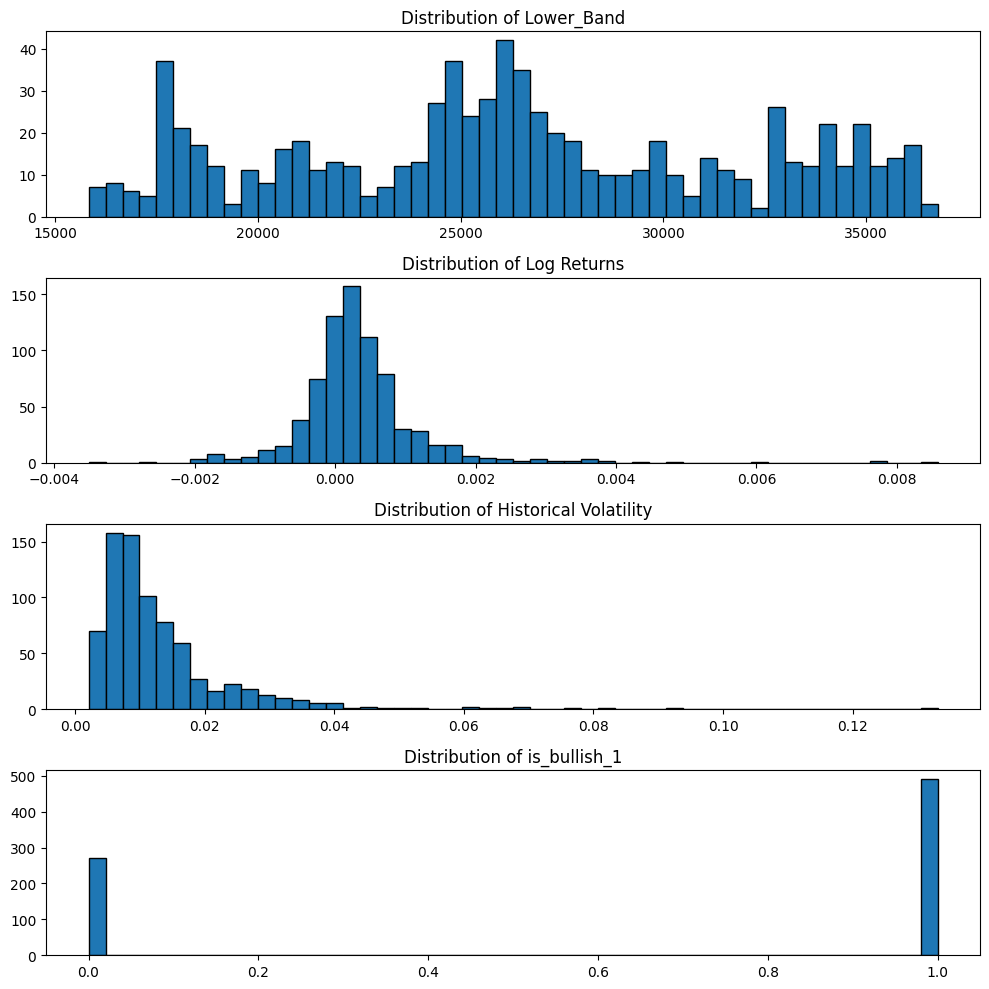

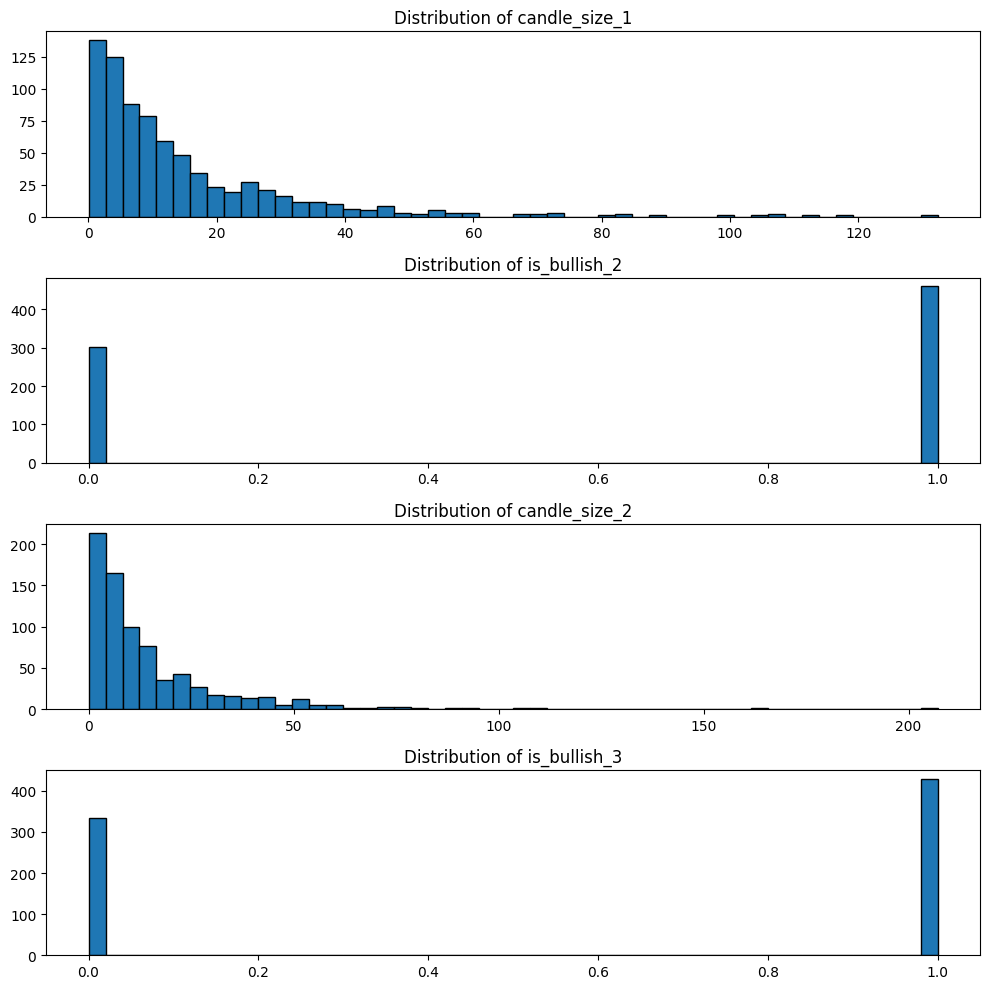

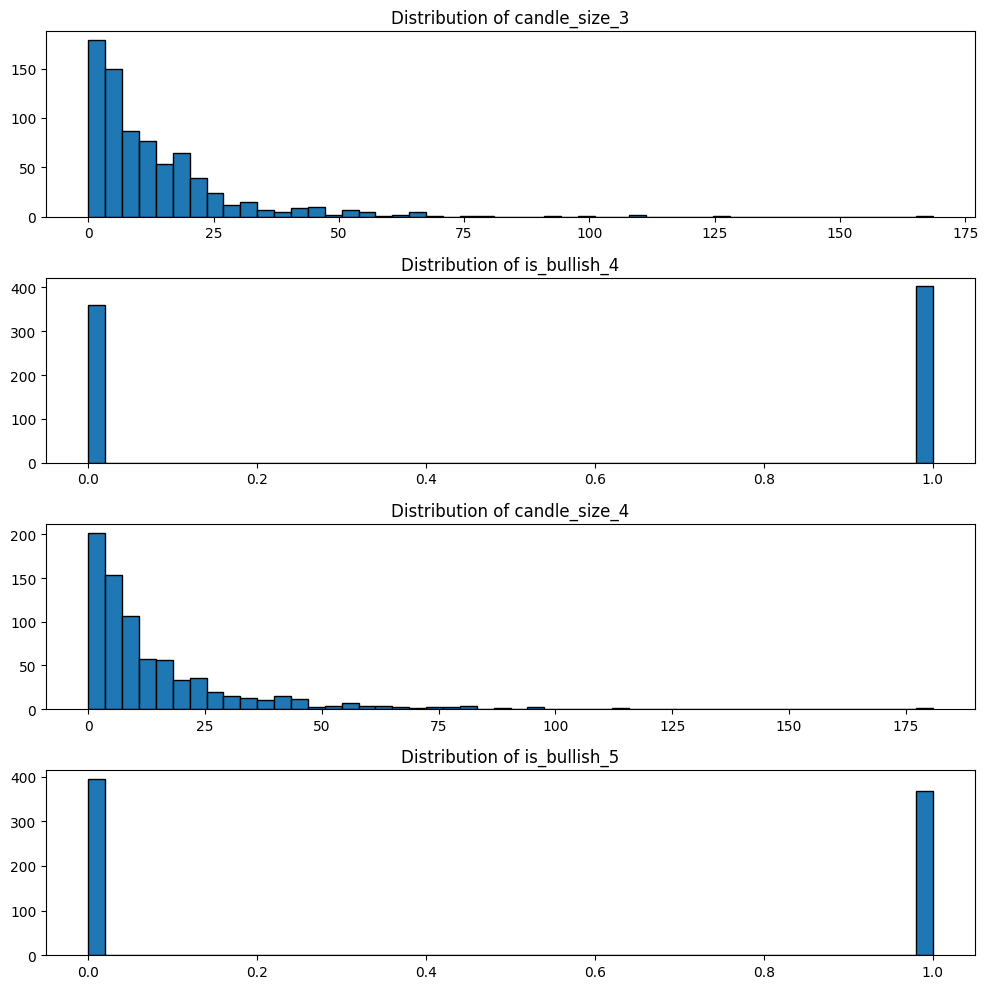

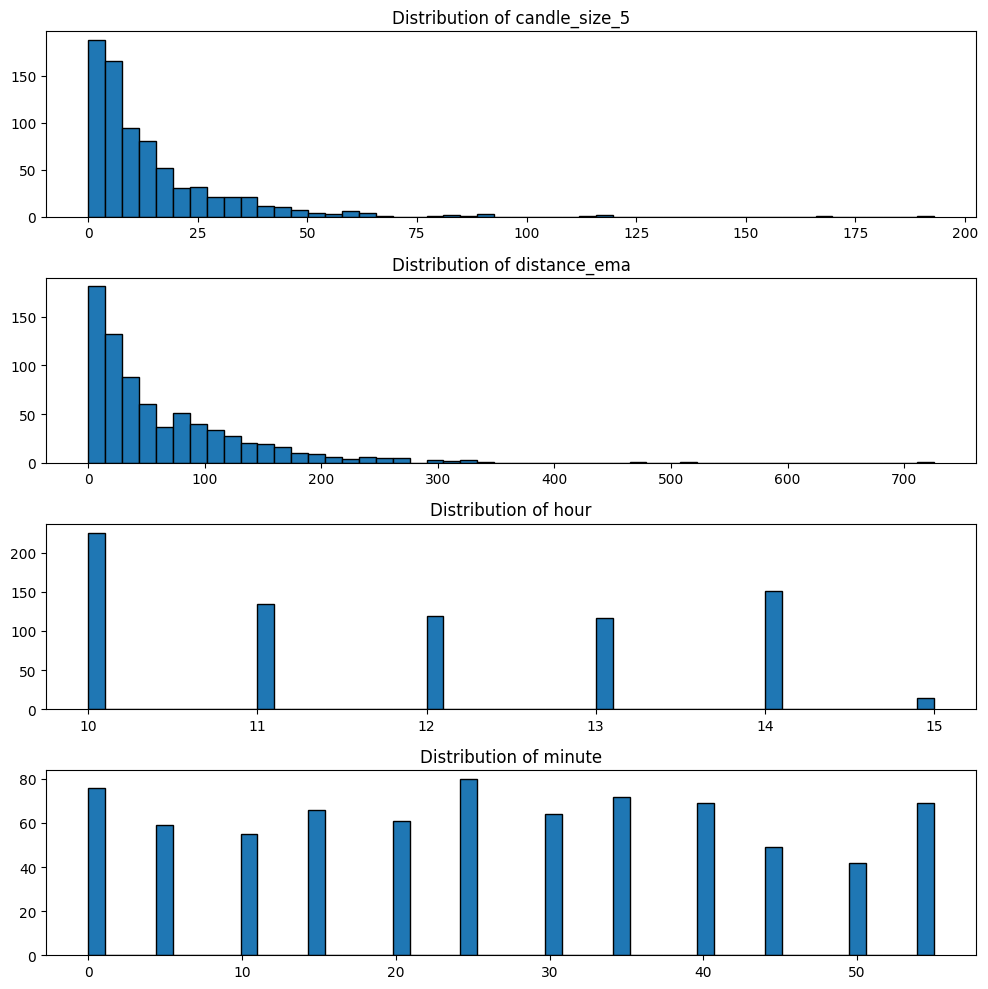

In [36]:
import math

# Define the number of subplots per figure
num_subplots_per_figure = 4

# Calculate the number of figures needed
num_figures = math.ceil(len(macd_buys.columns) / num_subplots_per_figure)

# Iterate over figures
for figure_num in range(num_figures):
    # Create a new figure
    fig, axs = plt.subplots(num_subplots_per_figure, figsize=(10, 10))
    
    # Determine the columns for this figure
    start_index = figure_num * num_subplots_per_figure
    end_index = start_index + num_subplots_per_figure
    cols_for_this_figure = macd_buys.columns[start_index:end_index]
    
    # Iterate over subplots
    for subplot_num, col in enumerate(cols_for_this_figure):
        axs[subplot_num].hist(macd_buys[col], bins=50, edgecolor='black')
        axs[subplot_num].set_title('Distribution of ' + col)
    
    # Show this figure
    plt.tight_layout()
    plt.show()

I want to now check for any outliers here. We can use the description tool to our advantage here. 



In [37]:
with pd.option_context('display.max_columns', None):
    display(macd_buys.describe())

,Points,Volume,MACD Line,Signal Line,is_bullish,is_bearish,candle_size,body_wick_ratio,ATR,RSI,MACD_Hist,ROC,HL,absHC,absLC,TR,20_SMA,20_SD,Upper_Band,Lower_Band,Log Returns,Historical Volatility,is_bullish_1,candle_size_1,is_bullish_2,candle_size_2,is_bullish_3,candle_size_3,is_bullish_4,candle_size_4,is_bullish_5,candle_size_5,distance_ema,hour,minute
count,762.000000,7.620000e+02,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000
mean,55.416325,2.601285e+06,-12.480694,-13.553703,0.709974,0.280840,16.259541,18.421095,26.440087,48.675469,1.073009,0.038899,26.930328,17.572572,9.460197,26.981549,26386.884136,33.600801,26454.085738,26319.682533,0.000363,0.013197,0.644357,14.513950,0.603675,14.321837,0.562992,13.623202,0.527559,13.881759,0.481627,14.845131,65.941876,11.834646,26.712598
std,47.074728,1.431720e+06,13.209748,14.095120,0.454072,0.449705,21.758277,91.348101,17.966053,5.420879,2.211133,0.157222,25.722937,23.123480,13.145637,25.753245,5570.114323,32.158469,5587.334702,5553.585455,0.000956,0.011318,0.479022,17.144832,0.489455,17.955740,0.496342,16.206397,0.499568,17.009146,0.499991,18.258419,72.925130,1.565548,17.066002
min,5.060000,0.000000e+00,-131.284593,-136.472422,0.000000,0.000000,0.010000,0.000000,5.008120,28.664656,-4.992507,-1.115839,2.300000,0.000000,0.000000,2.300000,15903.319500,3.608940,15982.692154,15823.946846,-0.003512,0.002099,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.125810,10.000000,0.000000
25%,25.087500,1.756002e+06,-15.740224,-17.850802,0.000000,0.000000,4.292500,0.405944,14.057349,45.139169,0.150277,-0.035327,11.697500,4.862500,1.347500,11.820000,22112.128750,14.306905,22142.101851,22010.574520,-0.000054,0.006705,0.000000,3.582500,0.000000,3.685000,0.000000,3.617500,0.000000,3.360000,0.000000,3.935000,15.866293,10.000000,15.000000
50%,42.410000,2.514400e+06,-8.035711,-8.799290,1.000000,0.000000,9.960000,1.801870,21.912227,49.168857,0.538814,0.021012,19.410000,11.535000,4.945000,19.410000,26163.160000,23.646851,26205.395877,26068.698485,0.000249,0.009947,1.000000,8.985000,1.000000,8.400000,1.000000,8.835000,1.000000,7.840000,0.000000,8.775000,40.304150,12.000000,25.000000
75%,70.747500,3.286486e+06,-4.027611,-4.540245,1.000000,1.000000,19.942500,6.343516,33.650871,52.567238,1.430318,0.084044,32.317500,22.117500,12.132500,32.317500,30935.541500,41.923787,31032.247654,30845.262316,0.000624,0.015709,1.000000,18.742500,1.000000,18.085000,1.000000,17.827500,1.000000,17.372500,1.000000,18.072500,95.784813,13.000000,40.000000
max,532.900000,9.524927e+06,4.566609,1.351154,1.000000,1.000000,265.770000,1365.500000,137.643790,64.214485,26.669585,1.085790,313.000000,279.450000,121.570000,313.000000,36812.431000,330.699438,36863.103006,36761.758994,0.008579,0.133091,1.000000,132.350000,1.000000,207.070000,1.000000,168.550000,1.000000,180.780000,1.000000,192.900000,725.587460,15.000000,55.000000


Given the substantial skew and difference in the 'body-wick ratio', it appears a log transformation could be highly beneficial for this specific feature. Log transformations are particularly useful for handling data that is heavily skewed, helping to normalize the distribution and make the data more interpretable for our model. So, we'll apply a log transformation to the 'body-wick ratio' to mitigate its skewness and potentially enhance the model's performance.




In [38]:
import numpy as np

# Get the columns that include 'candle_size' in their names
columns_to_transform = [col for col in macd_buys.columns if 'body_wick_ratio' in col]

# Apply log transformation to the selected columns
for col in columns_to_transform:
    macd_buys[col] = np.log(macd_buys[col] + 1)



In [39]:
map_target = {'WIN' : 1, 'LOSS' : 0}
macd_buys['Outcome'] = macd_buys['Outcome'].map(map_target)
macd_buys = macd_buys.dropna()
y = macd_buys.pop('Outcome')
X = macd_buys



Developing an ensemble method within a class structure is an excellent way to boost the readability and manageability of your code. This approach neatly packages various components of the ensemble model, such as individual estimators, their parameters, and the methods for training and predicting, into a well-structured, unified class. This arrangement not only simplifies the codebase, making it more maintainable, but it also enhances the clarity of the overall workflow of your ensemble model.

In [52]:
from sklearn.base import BaseEstimator, ClassifierMixin
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class EnsembleModel(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.xgb_model = xgb.XGBClassifier()
        self.svm_model = SVC()
        self.rf_model = RandomForestClassifier()
        self.lr_model = LogisticRegression(class_weight='balanced')

    def fit(self, X_train, y_train):        

        cost_of_false_positive = 1.0
        cost_of_false_negative = 2.0
        weights = np.where(y_train==0, cost_of_false_positive, cost_of_false_negative)

        xgb_params = {
            'objective': 'binary:logistic',
            'max_depth': 3,
            'learning_rate': 0.1,
            'n_estimators': 300,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0,
            'reg_alpha': 0.005
        }

        self.xgb_model.set_params(**xgb_params)
        self.xgb_model.fit(X_train, y_train, sample_weight=weights)

        svm_params = {
            'C' : 10,
            'gamma' : 'scale',
            'class_weight':{0:cost_of_false_positive, 1:cost_of_false_negative}
        }

        self.svm_model.set_params(**svm_params)
        self.svm_model.fit(X_train, y_train)
        
        rf_params = {
            'n_estimators':500, 
            'max_depth':3, 
            'class_weight':{0:cost_of_false_positive, 1:cost_of_false_negative}
        }
        self.rf_model.set_params(**rf_params)
        self.rf_model.fit(X_train, y_train)

        self.lr_model.fit(X_train, y_train)

        return self

    def predict(self, X):
        xgb_pred = self.xgb_model.predict(X)
        svm_pred = self.svm_model.predict(X)
        rf_pred = self.rf_model.predict(X)
        lr_pred = self.lr_model.predict(X)

        # Stack predictions
        stacked_pred = np.column_stack((xgb_pred, svm_pred, rf_pred, lr_pred))

        # Apply voting
        majority_vote_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=stacked_pred)

        return majority_vote_pred

In [53]:

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score


# Assuming you already have your features (X) and target (y)
ensemble_model = EnsembleModel()
cv = StratifiedKFold(n_splits=5)

# Define dictionary of metrics
scoring = {'accuracy': make_scorer(accuracy_score), 
           'precision': make_scorer(precision_score), 
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

scores = cross_validate(ensemble_model, X, y, cv=cv, scoring=scoring, return_train_score=True)

print("Train Accuracy: ", scores['train_accuracy'].mean())
print("Test Accuracy: ", scores['test_accuracy'].mean())
print("Train Precision: ", scores['train_precision'].mean())
print("Test Precision: ", scores['test_precision'].mean())
print("Train Recall: ", scores['train_recall'].mean())
print("Test Recall: ", scores['test_recall'].mean())
print("Train F1 Score: ", scores['train_f1'].mean())
print("Test F1 Score: ", scores['test_f1'].mean())

Train Accuracy:  0.7621104201997362
Test Accuracy:  0.4553663570691434
Train Precision:  0.6412440185307053
Test Precision:  0.38548225131241903
Train Recall:  0.9975741151887162
Test Recall:  0.5860391327340032
Train F1 Score:  0.7775868114027732
Test F1 Score:  0.4625544455838758
